In [1]:
# Python Image Library is a very useful library for processing images
from keras.models import Sequential, Model
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras.layers import Conv2D, MaxPooling2D
from keras import layers
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
import numpy as np
import pandas as pd
import cv2 
import os
import fnmatch
from sklearn import svm
from sklearn.metrics import accuracy_score
from tensorflow import keras
import tensorflow as tf
tf.config.run_functions_eagerly(True)

In [2]:
train_path = "Demo_dataset"
train_chinese = os.listdir(train_path)
df_train = pd.DataFrame(columns=["character", "filename", "label"])
len(train_chinese)

8

In [16]:
k = 0
for i in range(0, len(train_chinese)):
    if i != ".DS_Store":
        l = os.listdir(train_path + '/' + train_chinese[i])
        l = fnmatch.filter(l, '*.png')
        if len(l) > 200:
            l = l[:200]
        label = [k] * len(l)
        temp = pd.DataFrame({
            "character": train_chinese[i],
            "filename": l,
            "label": label
        })
        #print(temp)
        df_train = pd.concat([df_train, temp])      
    k += 1

In [17]:
df_train

,character,filename,label
0,理,176.png,0
1,理,88.png,0
2,理,162.png,0
3,理,189.png,0
4,理,77.png,0
...,...,...,...
195,鸫,93.png,7
196,鸫,78.png,7
197,鸫,186.png,7
198,鸫,192.png,7


In [18]:
train_array = np.zeros((df_train.shape[0], 128, 128, 3))
for i in range(df_train.shape[0]):
    if df_train.iloc[i]['filename'] != ".DS_Store":
        image_path = train_path + '/' + df_train.iloc[i]['character'] + '/' + df_train.iloc[i]['filename']
        # get grayscale image
        # print(image_path)
        image = cv2.imread(image_path)
        # remove noise
        out = cv2.medianBlur(image, 5)
        # normalize the image
        resultimage = np.zeros(out.shape)
        normalizedimage = cv2.normalize(out, resultimage, 0, 255, cv2.NORM_MINMAX)
        # resize the image 
        resizeimage = cv2.resize(normalizedimage, (128,128))

        blue, green, red = cv2.split(resizeimage) 
        # apply principal component analysis
        pca = PCA(50)
        red_transformed = pca.fit_transform(red)
        red_inverted = pca.inverse_transform(red_transformed)

        #Applying to Green channel and then applying inverse transform to transformed array.
        green_transformed = pca.fit_transform(green)
        green_inverted = pca.inverse_transform(green_transformed)

        #Applying to Blue channel and then applying inverse transform to transformed array.
        blue_transformed = pca.fit_transform(blue)
        blue_inverted = pca.inverse_transform(blue_transformed)

        img_compressed = (np.dstack((red_inverted, red_inverted, red_inverted))).astype(np.uint8)
        train_array[i] = img_compressed



In [19]:
train_array = train_array / 255

In [20]:
y = df_train["label"].to_numpy()

In [21]:
y = y.astype('int')

In [22]:
input_array = np.transpose(train_array, (0, 3, 1, 2))

In [23]:
input_array.shape

(1800, 3, 128, 128)

In [24]:
len(np.unique(y))

8

In [25]:
model = keras.models.Sequential([
    
    keras.layers.Conv2D(filters=64, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(128,128,3)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Conv2D(filters=128, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3)),
    keras.layers.Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=128, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Flatten(),
    
    keras.layers.Dense(1024,activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1024,activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(len(np.unique(y)),activation='softmax')  
    
])

In [26]:
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.optimizers.SGD(learning_rate=0.001),
    metrics=['accuracy']    
)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 30, 30, 64)        23296     
_________________________________________________________________
batch_normalization_4 (Batch (None, 30, 30, 64)        256       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 15, 15, 128)       204928    
_________________________________________________________________
batch_normalization_5 (Batch (None, 15, 15, 128)       512       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 5, 5, 128)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 5, 5, 128)        

In [27]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_array,y)

In [28]:
history=model.fit(
    X_train, y_train,
    epochs = 40,
    validation_data = (X_test, y_test),
    validation_freq = 1
)


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/data/ops/dataset_ops.py:4212: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/40
43/43 [==============================] - 7s 151ms/step - loss: 2.6320 - accuracy: 0.1822 - val_loss: 2.0766 - val_accuracy: 0.1489
Epoch 2/40
43/43 [==============================] - 7s 160ms/step - loss: 2.0610 - accuracy: 0.2889 - val_loss: 2.0790 - val_accuracy: 0.1422
Epoch 3/40
43/43 [==============================] - 7s 152ms/step - loss: 1.7369 - accuracy: 0.3933 - val_loss: 2.0749 - val_accuracy: 0.1889
Epoch 4/40
43/43 [==============================] - 7s 153ms/step - loss: 1.5478 - accuracy: 0.4578 - val_loss: 2.0251 - val_accuracy: 0.1978
Epoch 5/40
43/43 [==============================] - 6s 148ms/step - loss: 1.3568 - accuracy: 0.5237 - val_loss: 1.9340 - val_accuracy: 0.3022
Epoch 6/40
43/43 [==============================] - 7s 152ms/step - loss: 1.2367 - accuracy: 0.5719 - val_loss: 1.8039 - val_accuracy: 0.4378
Epoch 7/40
43/43 [==============================] - 6s 150ms/step - loss: 1.1111 - accuracy: 0.6281 - val_loss: 1.5651 - val_accuracy: 0.5022
Epoch 

<Figure size 720x720 with 0 Axes>

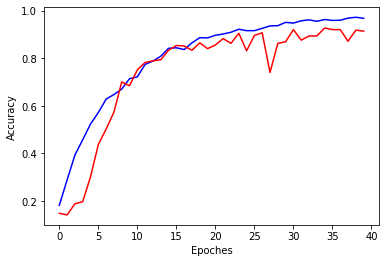

<Figure size 720x720 with 0 Axes>

In [29]:

plt.plot(model.history.history['accuracy'],color='b',label='Training  Accuracy')
plt.plot(model.history.history['val_accuracy'],color='r',label='Validation Accuracy')
plt.xlabel("Epoches")
plt.ylabel("Accuracy")
plt.figure(figsize = (10, 10))


In [30]:
np.max(history.history['val_accuracy'])

0.9266666769981384